In [1]:
###############################################################################
#                          1. Importing Libraries                             #
###############################################################################
# For reading, visualizing, and preprocessing data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import os 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

In [2]:
base_name = '18hr-pred'
base_dir = base_name + '/'

if not os.path.exists(base_name):
    os.makedirs(base_name)

In [3]:
###############################################################################
#                                 2. Get data                                 #
###############################################################################

full_df = pd.read_csv(base_dir + 'event_df.csv')
full_df['Y'] = (full_df['labresult'] < 72).astype(int)
model_df = full_df.dropna()
model_df.groupby("Y").mean().T



Y,0,1
Unnamed: 0,69101.844345,71276.227884
admissionWeight,85.866742,81.102468
admissionheight,169.621045,168.057751
age,64.040790,63.479160
gender,0.551171,0.502637
Caucasian,0.789971,0.724651
African American,0.108424,0.163746
Hispanic,0.029580,0.033004
Asian,0.012235,0.014376
BMI,291.524900,342.585628


In [4]:
###############################################################################
#                        3. Create train and test set                         #
###############################################################################

X_train, X_test, y_train, y_test = train_test_split(model_df.drop(['Y', 'Unnamed: 0', 'labresult'], axis = 1), model_df['Y'], test_size = 0.20,
                                                    random_state = 1000)

In [5]:
###############################################################################
#                               4. Classifiers                                #
###############################################################################
# Create list of tuples with classifier label and classifier object
classifiers = {}
classifiers.update({"LR" : LogisticRegression()})
classifiers.update({"LDA": LinearDiscriminantAnalysis()})
classifiers.update({"QDA": QuadraticDiscriminantAnalysis()})
classifiers.update({"AdaBoost": AdaBoostClassifier()})
classifiers.update({"Bagging": BaggingClassifier()})
classifiers.update({"Extra Trees Ensemble": ExtraTreesClassifier()})
classifiers.update({"Gradient Boosting": GradientBoostingClassifier()})
classifiers.update({"Random Forest": RandomForestClassifier()})
classifiers.update({"Ridge": RidgeClassifier()})
classifiers.update({"SGD": SGDClassifier()})
classifiers.update({"BNB": BernoulliNB()})
classifiers.update({"GNB": GaussianNB()})
classifiers.update({"KNN": KNeighborsClassifier()})
classifiers.update({"MLP": MLPClassifier()})
classifiers.update({"LSVC": LinearSVC()})
classifiers.update({"NuSVC": NuSVC()})
classifiers.update({"SVC": SVC()})
classifiers.update({"DTC": DecisionTreeClassifier()})
classifiers.update({"ETC": ExtraTreeClassifier()})

# Create dict of decision function labels
DECISION_FUNCTIONS = {"Ridge", "SGD", "LSVC", "NuSVC", "SVC"}

# Create dict for classifiers with feature_importances_ attribute
FEATURE_IMPORTANCE = {"Gradient Boosting", "Extra Trees Ensemble", "Random Forest"}


###############################################################################
#                             5. Hyper-parameters                             #
###############################################################################
# Initiate parameter grid
parameters = {}

parameters.update({ "LR" : {'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear'], 
                    'classifier__C' : [100, 10, 1.0, 0.1, 0.01],
                    'classifier__penalty': ['l2', 'l1'],
                     "classifier__n_jobs": [-1]}})


# Update dict with LDA
parameters.update({"LDA": {"classifier__solver": ["svd"], 
                                         }})

# Update dict with QDA
parameters.update({"QDA": {"classifier__reg_param":[0.01*ii for ii in range(0, 101)], 
                                         }})
# Update dict with AdaBoost
parameters.update({"AdaBoost": { 
                                "classifier__base_estimator": [DecisionTreeClassifier(max_depth = ii) for ii in range(1,6)],
                                "classifier__n_estimators": [200],
                                "classifier__learning_rate": [0.001, 0.01, 0.05, 0.1, 0.25, 0.50, 0.75, 1.0]
                                 }})

# Update dict with Bagging
parameters.update({"Bagging": { 
                                "classifier__base_estimator": [DecisionTreeClassifier(max_depth = ii) for ii in range(1,6)],
                                "classifier__n_estimators": [200],
                                "classifier__max_features": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                "classifier__n_jobs": [-1]
                                }})

# Update dict with Gradient Boosting
parameters.update({"Gradient Boosting": { 
                                        "classifier__learning_rate":[0.15,0.1,0.05,0.01,0.005,0.001], 
                                        "classifier__n_estimators": [200],
                                        "classifier__max_depth": [2,3,4,5,6],
                                        "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                                        "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                                        "classifier__max_features": ["auto", "sqrt", "log2"],
                                        "classifier__subsample": [0.8, 0.9, 1]
                                         }})


# Update dict with Extra Trees
parameters.update({"Extra Trees Ensemble": { 
                                            "classifier__n_estimators": [200],
                                            "classifier__class_weight": [None, "balanced"],
                                            "classifier__max_features": ["auto", "sqrt", "log2"],
                                            "classifier__max_depth" : [3, 4, 5, 6, 7, 8],
                                            "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                                            "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                                            "classifier__criterion" :["gini", "entropy"]     ,
                                            "classifier__n_jobs": [-1]
                                             }})


# Update dict with Random Forest Parameters
parameters.update({"Random Forest": { 
                                    "classifier__n_estimators": [200],
                                    "classifier__class_weight": [None, "balanced"],
                                    "classifier__max_features": ["auto", "sqrt", "log2"],
                                    "classifier__max_depth" : [3, 4, 5, 6, 7, 8],
                                    "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                                    "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                                    "classifier__criterion" :["gini", "entropy"]     ,
                                    "classifier__n_jobs": [-1]
                                     }})

# Update dict with Ridge
parameters.update({"Ridge": { 
                            "classifier__alpha": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.50, 0.75, 1.0]
                             }})

# Update dict with SGD Classifier
parameters.update({"SGD": { 
                            "classifier__alpha": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.50, 0.75, 1.0],
                            "classifier__penalty": ["l1", "l2"],
                            "classifier__n_jobs": [-1]
                             }})


# Update dict with BernoulliNB Classifier
parameters.update({"BNB": { 
                            "classifier__alpha": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.50, 0.75, 1.0]
                             }})

# Update dict with GaussianNB Classifier
parameters.update({"GNB": { 
                            "classifier__var_smoothing": [1e-9, 1e-8,1e-7, 1e-6, 1e-5]
                             }})

# Update dict with K Nearest Neighbors Classifier
parameters.update({"KNN": { 
                            "classifier__n_neighbors": list(range(1,31)),
                            "classifier__p": [1, 2, 3, 4, 5],
                            "classifier__leaf_size": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                            "classifier__n_jobs": [-1]
                             }})

# Update dict with MLPClassifier
parameters.update({"MLP": { 
                            "classifier__hidden_layer_sizes": [(5), (10), (5,5), (10,10), (5,5,5), (10,10,10)],
                            "classifier__activation": ["identity", "logistic", "tanh", "relu"],
                            "classifier__learning_rate": ["constant", "invscaling", "adaptive"],
                            "classifier__max_iter": [100, 200, 300, 500, 1000, 2000],
                            "classifier__alpha": list(10.0 ** -np.arange(1, 10)),
                             }})

parameters.update({"LSVC": { 
                            "classifier__penalty": ["l2"],
                            "classifier__C": [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100]
                             }})

parameters.update({"NuSVC": { 
                            "classifier__nu": [0.25, 0.50, 0.75],
                            "classifier__kernel": ["linear", "rbf", "poly"],
                            "classifier__degree": [1,2,3,4,5,6],
                             }})

parameters.update({"SVC": { 
                            "classifier__kernel": ["linear", "rbf", "poly"],
                            "classifier__gamma": ["auto"],
                            "classifier__C": [0.1, 0.5, 1, 5, 10, 50, 100],
                            "classifier__degree": [1, 2, 3, 4, 5, 6]
                             }})


# Update dict with Decision Tree Classifier
parameters.update({"DTC": { 
                            "classifier__criterion" :["gini", "entropy"],
                            "classifier__splitter": ["best", "random"],
                            "classifier__class_weight": [None, "balanced"],
                            "classifier__max_features": ["auto", "sqrt", "log2"],
                            "classifier__max_depth" : [1,2,3, 4, 5, 6, 7, 8],
                            "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                            "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                             }})

# Update dict with Extra Tree Classifier
parameters.update({"ETC": { 
                            "classifier__criterion" :["gini", "entropy"],
                            "classifier__splitter": ["best", "random"],
                            "classifier__class_weight": [None, "balanced"],
                            "classifier__max_features": ["auto", "sqrt", "log2"],
                            "classifier__max_depth" : [1,2,3, 4, 5, 6, 7, 8],
                            "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                            "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                             }})


['Hgb']


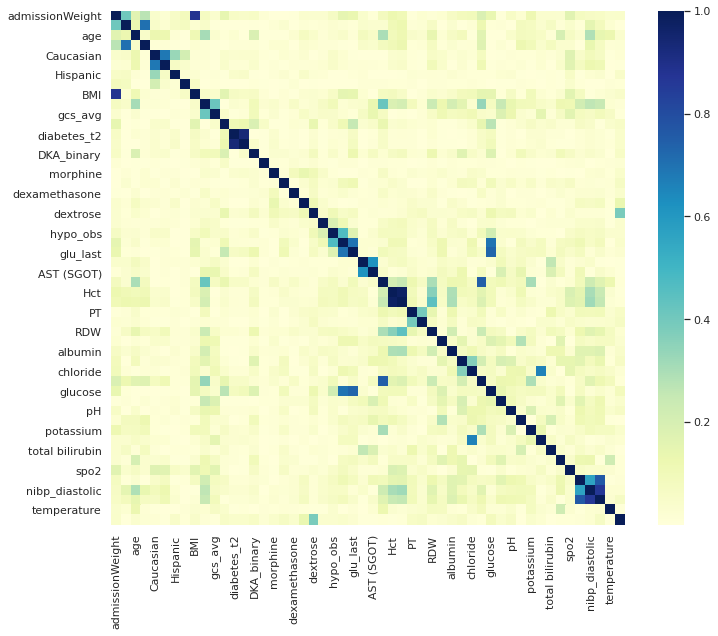

In [6]:
###############################################################################
#              6. Feature Selection: Removing highly correlated features      #
###############################################################################
# Filter Method: Spearman's Cross Correlation > 0.95
# Make correlation matrix
corr_matrix = X_train.corr(method = "spearman").abs()

# Draw the heatmap
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax = ax)
f.tight_layout()
plt.savefig("correlation_matrix.png", dpi = 1080)

# Select upper triangle of matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(to_drop)

# # Drop features
# X_train = X_train.drop(to_drop, axis = 1)
# X_test = X_test.drop(to_drop, axis = 1)


In [7]:
###############################################################################
#                     7. Tuning a classifier to use with RFECV                #
###############################################################################
# Define classifier to use as the base of the recursive feature elimination algorithm
selected_classifier = "Random Forest"
classifier = classifiers[selected_classifier]

# Tune classifier (Took = 4.8 minutes)
    
# Scale features via Z-score normalization
scaler = StandardScaler()

# Define steps in pipeline
steps = [("scaler", scaler), ("classifier", classifier)]

# Initialize Pipeline object
pipeline = Pipeline(steps = steps)
  
# Define parameter grid
param_grid = parameters[selected_classifier]

# Initialize GridSearch object
gscv = GridSearchCV(pipeline, param_grid, cv = 5,  n_jobs= -1, verbose = 1, scoring = "roc_auc")
                  
# Fit gscv
print(f"Now tuning {selected_classifier}. Go grab a beer or something.")
gscv.fit(X_train, np.ravel(y_train))  

# Get best parameters and score
best_params = gscv.best_params_
best_score = gscv.best_score_
        
# Update classifier parameters
tuned_params = {item[12:]: best_params[item] for item in best_params}
classifier.set_params(**tuned_params)


Now tuning Random Forest. Go grab a beer or something.
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1130 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1680 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 2330 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 3080 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 3930 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 4880 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed: 20.5min finished


RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_leaf=0.005,
                       min_samples_split=0.01, n_estimators=200, n_jobs=-1)

In [8]:
###############################################################################
#                  8. Custom pipeline object to use with RFECV                #
###############################################################################
# Select Features using RFECV
class PipelineRFE(Pipeline):
    # Source: https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/
    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self


In [9]:
###############################################################################
#   9. Feature Selection: Recursive Feature Selection with Cross Validation   #
###############################################################################
# Define pipeline for RFECV
steps = [("scaler", scaler), ("classifier", classifier)]
pipe = PipelineRFE(steps = steps)

# Initialize RFECV object
feature_selector = RFECV(pipe, cv = 5, step = 1, scoring = "roc_auc", verbose = 1)

# Fit RFECV
feature_selector.fit(X_train, np.ravel(y_train))

# Get selected features
feature_names = X_train.columns
selected_features = feature_names[feature_selector.support_].tolist()


Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 fe

Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.


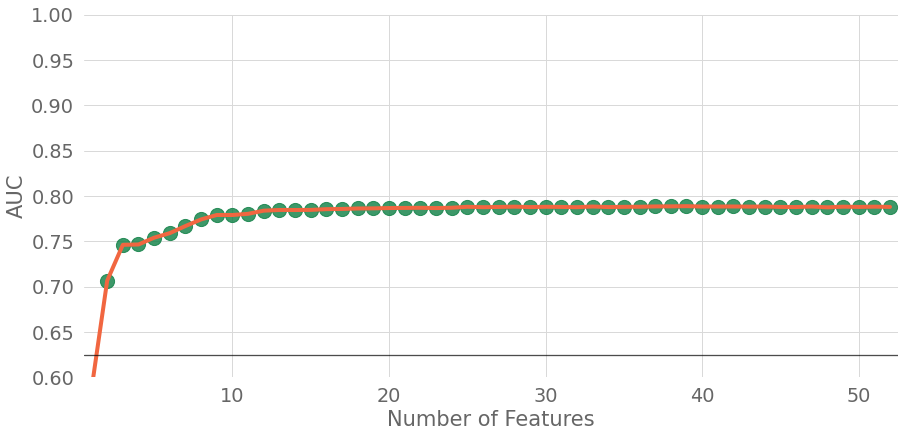

In [10]:
###############################################################################
#                             10. Performance Curve                           #
###############################################################################
# Get Performance Data
performance_curve = {"Number of Features": list(range(1, len(feature_names) + 1)),
                    "AUC": feature_selector.grid_scores_}
performance_curve = pd.DataFrame(performance_curve)

# Performance vs Number of Features
# Set graph style
sns.set(font_scale = 1.75)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})
colors = sns.color_palette("RdYlGn", 20)
line_color = colors[3]
marker_colors = colors[-1]

# Plot
f, ax = plt.subplots(figsize=(13, 6.5))
sns.lineplot(x = "Number of Features", y = "AUC", data = performance_curve,
             color = line_color, lw = 4, ax = ax)
sns.regplot(x = performance_curve["Number of Features"], y = performance_curve["AUC"],
            color = marker_colors, fit_reg = False, scatter_kws = {"s": 200}, ax = ax)

# Axes limits
plt.xlim(0.5, len(feature_names)+0.5)
plt.ylim(0.60, 1)

# Generate a bolded horizontal line at y = 0
ax.axhline(y = 0.625, color = 'black', linewidth = 1.3, alpha = .7)

# Turn frame off
ax.set_frame_on(False)

# Tight layout
plt.tight_layout()

# Save Figure
plt.savefig(base_dir + "performance_curve.png", dpi = 1080)


In [11]:
#Change number of features below:

###############################################################################
#                11. Feature Selection: Recursive Feature Selection           #
###############################################################################
# Define pipeline for RFECV
steps = [("scaler", scaler), ("classifier", classifier)]
pipe = PipelineRFE(steps = steps)

# Initialize RFE object
feature_selector = RFE(pipe, n_features_to_select = 25, step = 1, verbose = 1)

# Fit RFE
feature_selector.fit(X_train, np.ravel(y_train))

# Get selected features labels
feature_names = X_train.columns
selected_features = feature_names[feature_selector.support_].tolist()

Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.


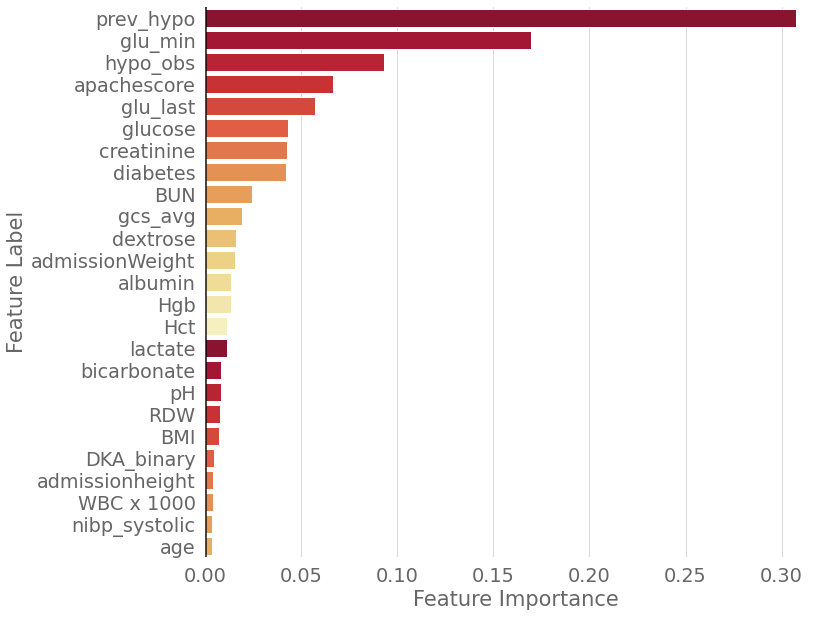

In [12]:
###############################################################################
#                  12. Visualizing Selected Features Importance               #
###############################################################################
# Get selected features data set
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# Train classifier
classifier.fit(X_train, np.ravel(y_train))

# Get feature importance
feature_importance = pd.DataFrame(selected_features, columns = ["Feature Label"])
feature_importance["Feature Importance"] = classifier.feature_importances_

# Sort by feature importance
feature_importance = feature_importance.sort_values(by="Feature Importance", ascending=False)

# Set graph style
sns.set(font_scale = 1.75)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})

# Set figure size and create barplot
f, ax = plt.subplots(figsize=(12, 9))
sns.barplot(x = "Feature Importance", y = "Feature Label",
            palette = reversed(sns.color_palette('YlOrRd', 15)),  data = feature_importance)

# Generate a bolded horizontal line at y = 0
ax.axvline(x = 0, color = 'black', linewidth = 4, alpha = .7)

# Turn frame off
ax.set_frame_on(False)

# Tight layout
plt.tight_layout()

# Save Figure
plt.savefig(base_dir + "feature_importance.png", dpi = 1080)


In [13]:
def performanceTest(realtarget,predictedtarget,verbose=False):

    print('\nComputing Confusion Matrix')
    
    res = []
    # Create list of threshold to be assessed
    _, _, list_threshold = roc_curve(realtarget, predictedtarget)

    # Calculate performance for each threshold
    for thr in list_threshold:
        p = np.copy(predictedtarget)


        # Get AUC
        fpr, tpr, _ = roc_curve(realtarget, p)
        auroc_p = auc(fpr, tpr)

        # Classification
        p[p < thr] = 0; # inferior
        p[p != 0] = 1; # sup or equal

        # Get AUPR
        precision, recall, _ = precision_recall_curve(realtarget, p)
        aupr_p = auc(recall, precision)

        # Confusion matrix
        matrix = confusion_matrix(realtarget, p)

        # Metrics
        acc = accuracy_score(realtarget, p)
        sens = recall_score(realtarget, p) # or recall
        spec = matrix[0,0]/(matrix[0,0]+matrix[0,1]) # TN/TN+FP
        pr = precision_score(realtarget, p)

        df_tmp = pd.DataFrame({'Threshold': [thr], 'Accuracy': [acc],
                               'Precision' : [pr],'Specificity': [spec],
                               'Sensitivity': [sens],'AUC': [auroc_p],
                               'AUPR': [aupr_p]})

        res.append(df_tmp)

    # The next measures are not independent from the threshold.
    res = pd.concat(res, axis=0)
    res.index = pd.RangeIndex(start=0, stop=len(list_threshold), step=1)

    thr_delta = res.loc[(res.Sensitivity - res.Specificity).abs().idxmin()]

    thr_prec = res.loc[res.Precision.idxmax()]
    score_loss = thr_delta.Sensitivity + thr_delta.Specificity

    d_thr_delta =  dict(thr_delta)
    d_thr_prec = dict(thr_prec)

    return d_thr_delta, d_thr_prec, thr_delta


In [20]:
results_file = open(base_dir + "results.txt", "w")
results_file.close()

In [ ]:
###############################################################################
#                       13. Classifier Tuning and Evaluation                  #
###############################################################################
# Initialize dictionary to store results
results = {}


# Tune and evaluate classifiers
for classifier_label, classifier in classifiers.items():
    # Print message to user
    print(f"Now tuning {classifier_label}.")
    
    # Scale features via Z-score normalization
    scaler = StandardScaler()
    
    # Define steps in pipeline
    steps = [("scaler", scaler), ("classifier", classifier)]
    
    # Initialize Pipeline object
    pipeline = Pipeline(steps = steps)
      
    # Define parameter grid
    param_grid = parameters[classifier_label]
    
    # Initialize GridSearch object
    gscv = GridSearchCV(pipeline, param_grid, cv = 5,  n_jobs= -1, verbose = 1, scoring = "roc_auc")
                      
    # Fit gscv
    gscv.fit(X_train, np.ravel(y_train))  
    
    # Get best parameters and score
    best_params = gscv.best_params_
    best_score = gscv.best_score_
    
    # Update classifier parameters and define new pipeline with tuned classifier
    tuned_params = {item[12:]: best_params[item] for item in best_params}
    classifier.set_params(**tuned_params)
            
    # Make predictions
    if classifier_label in DECISION_FUNCTIONS:
        y_pred = gscv.decision_function(X_test)
    else:
        y_pred = gscv.predict_proba(X_test)[:,1]
    
        
    # Evaluate model
    auc_roc = metrics.roc_auc_score(y_test, y_pred)
    
    results_file = open(base_dir + "results.txt", "a")

    results_file.write('\n\n\n\nModel Name: {}'.format(classifier_label))
    results_file.write('\nTraining AUC' + ': ' + str(np.round(best_score, 4)))
    results_file.write('\nTest AUC' + ': ' + str(np.round(auc_roc, 3)))
    
    results_p, results_prec, df_delta = performanceTest(y_test, y_pred)
        
    results_file.write('\n\nResults on Test Set Prediction (min delta):')
    for y in results_p.keys():
        results_file.write("\n" + str(y) + ': ' + str(np.round(results_p[y], 4)))

    results_file.write('\n\nResults on Test Set Prediction (max precision):')
    for y in results_prec.keys():
        results_file.write("\n" + str(y) + ': ' + str(np.round(results_prec[y], 4)))
        
    results_file.close()
    
    # Save results
    result = {"Classifier": gscv,
              "Best Parameters": best_params,
              "Training AUC": best_score,
              "Test AUC": auc_roc}
    
    results.update({classifier_label: result})
    
    print(result)


Now tuning LR.
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    6.0s finished
/home/smantena/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 60.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Computing Confusion Matrix


/home/smantena/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(C=0.01, n_jobs=-1,
                                                           penalty='l1',
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'classifier__C': [100, 10, 1.0, 0.1, 0.01],
                         'classifier__n_jobs': [-1],
                         'classifier__penalty': ['l2', 'l1'],
                         'classifier__solver': ['newton-cg', 'lbfgs',
                                                'liblinear']},
             scoring='roc_auc', verbose=1), 'Best Parameters': {'classifier__C': 0.01, 'classifier__n_jobs': -1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}, 'Training AUC': 0.7718639742864519, 'Test AUC': 0.7657723746839707}
Now tuning LDA.
Fittin

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished



Computing Confusion Matrix


/home/smantena/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        LinearDiscriminantAnalysis())]),
             n_jobs=-1, param_grid={'classifier__solver': ['svd']},
             scoring='roc_auc', verbose=1), 'Best Parameters': {'classifier__solver': 'svd'}, 'Training AUC': 0.7733876926716508, 'Test AUC': 0.7675438613279644}
Now tuning QDA.
Fitting 5 folds for each of 101 candidates, totalling 505 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 331 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 505 out of 505 | elapsed:    6.9s finished



Computing Confusion Matrix


/home/smantena/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        QuadraticDiscriminantAnalysis(reg_param=0.47000000000000003))]),
             n_jobs=-1,
             param_grid={'classifier__reg_param': [0.0, 0.01, 0.02, 0.03, 0.04,
                                                   0.05, 0.06, 0.07, 0.08, 0.09,
                                                   0.1, 0.11, 0.12, 0.13, 0.14,
                                                   0.15, 0.16, 0.17, 0.18, 0.19,
                                                   0.2, 0.21, 0.22, 0.23, 0.24,
                                                   0.25, 0.26, 0.27, 0.28, 0.29, ...]},
             scoring='roc_auc', verbose=1), 'Best Parameters': {'classifier__reg_param': 0.47000000000000003}, 'Training AUC': 0.7663803123834362, 'Test AUC': 0.7602049190524767}
Now tuning AdaBoost.
Fitting 5 folds for each

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.3min finished



Computing Confusion Matrix


/home/smantena/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                                                           learning_rate=0.1,
                                                           n_estimators=200))]),
             n_jobs=-1,
             param_grid={'classifier__base_estimator': [DecisionTreeClassifier(max_depth=1),
                                                        DecisionTreeClassifier(max_depth=2),
                                                        DecisionTreeClassifier(max_depth=3),
                                                        DecisionTreeClassifier(max_depth=4),
                                                        DecisionTreeClassifier(max_depth=5)],
                         'classifier__learning_rate': [0.001, 0.01, 0.05, 0.1,
    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:  1.6min finished



Computing Confusion Matrix


/home/smantena/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                                                          max_features=0.4,
                                                          n_estimators=200,
                                                          n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'classifier__base_estimator': [DecisionTreeClassifier(max_depth=1),
                                                        DecisionTreeClassifier(max_depth=2),
                                                        DecisionTreeClassifier(max_depth=3),
                                                        DecisionTreeClassifier(max_depth=4),
                                                        DecisionTreeClassifier(max_depth=5)],
                  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 1130 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1680 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2330 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3080 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 3930 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 4880 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed:  7.7min finished



Computing Confusion Matrix


/home/smantena/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        ExtraTreesClassifier(max_depth=8,
                                                             min_samples_leaf=0.005,
                                                             min_samples_split=0.005,
                                                             n_estimators=200,
                                                             n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'classifier__class_weight': [None, 'balanced'],
                         'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [3, 4, 5, 6, 7, 8],
                         'classifier__max_features': ['auto', 'sqrt', 'log2'],
                         'classifier__min_samples_leaf': [0.005, 0.01, 0.05,
                                                 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1130 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1680 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 2330 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 3080 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done 3930 tasks      | elapsed: 29.0min
[Parallel(n_jobs=-1)]: Done 4880 tasks      | elapsed: 34.0min
[Parallel(n_jobs=-1)]: Done 5930 tasks      | elapsed: 43.5min
[Parallel(n_jobs=-1)]: Done 7080 tasks      | elapsed: 53.1min
[Parallel(n_jobs=-1)]: Done 8330 tasks      | elapsed: 60.3min
[Parallel(n_jobs=-1)]: Done 9680 tasks      | elapsed: 71.6min
[Parallel(n_jobs=-1)]: Done 11130 tasks      | elapsed: 82.6min
[Parallel(n_jobs=-1)]: Done 12680 tasks    


Computing Confusion Matrix


/home/smantena/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        GradientBoostingClassifier(learning_rate=0.05,
                                                                   max_depth=6,
                                                                   max_features='auto',
                                                                   min_samples_leaf=0.01,
                                                                   min_samples_split=0.005,
                                                                   n_estimators=200,
                                                                   subsample=0.8))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.15, 0.1, 0.05, 0.01,
                                                       0.005, 0.001],
                         'classifier__max_depth': [2, 3, 4, 5, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1130 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1680 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 2330 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 3080 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 3930 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 4880 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed: 20.1min finished



Computing Confusion Matrix


/home/smantena/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier(criterion='entropy',
                                                               max_depth=8,
                                                               min_samples_leaf=0.005,
                                                               min_samples_split=0.01,
                                                               n_estimators=200,
                                                               n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'classifier__class_weight': [None, 'balanced'],
                         'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [3, 4, 5, 6, 7, 8],
                         'classifier__max_features': ['auto', 'sqrt', 'log2'],
                         'classif

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  55 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.6s finished



Computing Confusion Matrix


/home/smantena/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        RidgeClassifier(alpha=0.001))]),
             n_jobs=-1,
             param_grid={'classifier__alpha': [1e-07, 1e-06, 1e-05, 0.0001,
                                               0.001, 0.01, 0.1, 0.25, 0.5,
                                               0.75, 1.0]},
             scoring='roc_auc', verbose=1), 'Best Parameters': {'classifier__alpha': 0.001}, 'Training AUC': 0.7733877046291882, 'Test AUC': 0.7675438613279644}
Now tuning SGD.
Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 out of 110 | elapsed:    2.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    4.1s finished



Computing Confusion Matrix


/home/smantena/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        SGDClassifier(n_jobs=-1,
                                                      penalty='l1'))]),
             n_jobs=-1,
             param_grid={'classifier__alpha': [1e-07, 1e-06, 1e-05, 0.0001,
                                               0.001, 0.01, 0.1, 0.25, 0.5,
                                               0.75, 1.0],
                         'classifier__n_jobs': [-1],
                         'classifier__penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=1), 'Best Parameters': {'classifier__alpha': 0.0001, 'classifier__n_jobs': -1, 'classifier__penalty': 'l1'}, 'Training AUC': 0.7244866943179924, 'Test AUC': 0.6440496536835477}
Now tuning BNB.
Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  55 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.5s finished



Computing Confusion Matrix


/home/smantena/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', BernoulliNB())]),
             n_jobs=-1,
             param_grid={'classifier__alpha': [1e-07, 1e-06, 1e-05, 0.0001,
                                               0.001, 0.01, 0.1, 0.25, 0.5,
                                               0.75, 1.0]},
             scoring='roc_auc', verbose=1), 'Best Parameters': {'classifier__alpha': 1.0}, 'Training AUC': 0.7508632295608046, 'Test AUC': 0.7452424980717666}
Now tuning GNB.
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.4s finished



Computing Confusion Matrix


/home/smantena/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        GaussianNB(var_smoothing=1e-05))]),
             n_jobs=-1,
             param_grid={'classifier__var_smoothing': [1e-09, 1e-08, 1e-07,
                                                       1e-06, 1e-05]},
             scoring='roc_auc', verbose=1), 'Best Parameters': {'classifier__var_smoothing': 1e-05}, 'Training AUC': 0.752076302985951, 'Test AUC': 0.7465625005980873}
Now tuning KNN.
Fitting 5 folds for each of 1500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed: 29.4min
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed: 66.1min
[Parallel(n_jobs=-1)]: Done 1130 tasks      | elapsed: 111.1min
[Parallel(n_jobs=-1)]: Done 1680 tasks      | elapsed: 174.7min
[Parallel(n_jobs=-1)]: Done 2330 tasks      | elapsed: 257.4min


In [ ]:
###############################################################################
#                              14. Visualing Results                          #
###############################################################################
# Initialize auc_score dictionary
auc_scores = {
              "Classifier": [],
              "AUC": [],
              "AUC Type": []
              }

# Get AUC scores into dictionary
for classifier_label in results:
    auc_scores.update({"Classifier": [classifier_label] + auc_scores["Classifier"],
                       "AUC": [results[classifier_label]["Training AUC"]] + auc_scores["AUC"],
                       "AUC Type": ["Training"] + auc_scores["AUC Type"]})
    
    auc_scores.update({"Classifier": [classifier_label] + auc_scores["Classifier"],
                       "AUC": [results[classifier_label]["Test AUC"]] + auc_scores["AUC"],
                       "AUC Type": ["Test"] + auc_scores["AUC Type"]})

# Dictionary to PandasDataFrame
auc_scores = pd.DataFrame(auc_scores)

# Set graph style
sns.set(font_scale = 1.75)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})

    
# Colors
training_color = sns.color_palette("RdYlBu", 10)[1]
test_color = sns.color_palette("RdYlBu", 10)[-2]
colors = [training_color, test_color]

# Set figure size and create barplot
f, ax = plt.subplots(figsize=(12, 9))

sns.barplot(x="AUC", y="Classifier", hue="AUC Type", palette = colors,
            data=auc_scores)

# Generate a bolded horizontal line at y = 0
ax.axvline(x = 0, color = 'black', linewidth = 4, alpha = .7)

# Turn frame off
ax.set_frame_on(False)

# Tight layout
plt.tight_layout()

# Save Figure
plt.savefig("AUC Scores.png", dpi = 1080)

In [ ]:
auc_scores.to_csv('auc_scores.csv')
auc_scores